## Konfigurasi dan Impor Pustaka

Tahap awal ini adalah untuk mengimpor semua pustaka yang dibutuhkan dan mendefinisikan semua parameter, nama kolom, serta path file dalam satu lokasi terpusat agar mudah dikelola.

In [16]:
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# --- KONFIGURASI PROYEK ---

# Path File
FILE_PATH = 'cleaned_heart_dataset.csv'
PREPROCESSOR_PATH = 'tf_ohe_preprocessor.pkl'
MODEL_PATH = 'best_mlp_ohe_model.keras'

# Definisi Kolom
TARGET_COLUMN = 'target'
CATEGORICAL_COLS = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope']
NUMERICAL_COLS = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Hyperparameter Model
MODEL_CONFIG = {
    'input_shape': None, # Akan diisi setelah preprocessing
    'hidden_units': [128, 64, 32],
    'dropout_rate': 0.3,
    'learning_rate': 0.001,
    'weight_decay': 0.01,
    'epochs': 200,
    'batch_size': 32,
    'early_stopping_patience': 50
}

## Persiapan Data

Fungsi-fungsi di bawah ini bertanggung jawab untuk memuat data, memisahkannya menjadi set pelatihan, validasi, dan tes, serta mendefinisikan dan menerapkan preprocessor.

In [17]:
def load_data(filepath):
    """Memuat data dari file CSV."""
    print(f"Memuat data dari: {filepath}")
    return pd.read_csv(filepath)

def create_preprocessor(numerical_cols, categorical_cols):
    """Membuat ColumnTransformer untuk preprocessing data."""
    return ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
        ],
        remainder='drop'
    )

def split_data(df, target_column):
    """Memisahkan fitur dan target, lalu membaginya menjadi set train, validation, dan test."""
    y = df[target_column]
    X = df.drop(target_column, axis=1)
    
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    print("Ukuran dataset setelah pemisahan:")
    print(f"  - Data Latih      : {X_train.shape[0]} sampel")
    print(f"  - Data Validasi   : {X_val.shape[0]} sampel")
    print(f"  - Data Tes        : {X_test.shape[0]} sampel")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

## Pembangunan dan Pelatihan Model

Fungsi-fungsi ini mendefinisikan arsitektur model neural network, mengompilasinya, dan melatihnya menggunakan data yang telah diproses.

In [18]:
def build_model(config):
    """Membangun arsitektur model Sequential TensorFlow."""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(config['input_shape'],)),
        tf.keras.layers.Dense(config['hidden_units'][0], activation='relu'),
        tf.keras.layers.Dropout(config['dropout_rate']),
        tf.keras.layers.Dense(config['hidden_units'][1], activation='relu'),
        tf.keras.layers.Dropout(config['dropout_rate']),
        tf.keras.layers.Dense(config['hidden_units'][2], activation='relu'),
        tf.keras.layers.Dropout(config['dropout_rate']),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(
            learning_rate=config['learning_rate'], 
            weight_decay=config['weight_decay']
        ),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

def train_model(model, X_train, y_train, X_val, y_val, config, model_path):
    """Melatih model dengan callbacks."""
    early_stopping = tf.keras.callbacks.EarlyStopping(
        patience=config['early_stopping_patience'], 
        restore_best_weights=True, 
        monitor='val_auc', 
        mode='max'
    )
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        model_path, 
        save_best_only=True, 
        monitor='val_auc', 
        mode='max'
    )
    
    print(f"\nMemulai pelatihan untuk {config['epochs']} epochs...")
    history = model.fit(
        X_train, y_train,
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )
    print("Pelatihan selesai.")
    return history

## Evaluasi dan Visualisasi

Fungsi di bawah ini digunakan untuk mengevaluasi performa model pada data tes dan memvisualisasikan hasilnya.

In [19]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """Mengevaluasi model pada data tes dan menampilkan hasilnya."""
    print(f"\n--- Mengevaluasi {model_name} pada Test Set ---")
    
    # Evaluasi umum
    loss, acc, auc = model.evaluate(X_test, y_test, verbose=0)
    print(f"  - Test Loss     : {loss:.4f}")
    print(f"  - Test Accuracy : {acc:.4f}")
    print(f"  - Test AUC      : {auc:.4f}")
    
    # Prediksi untuk metrik lain
    y_pred_proba = model.predict(X_test).ravel()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Kalkulasi Precision, Recall, F1-Score
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    print(f"  - Test Precision: {precision:.4f}")
    print(f"  - Test Recall   : {recall:.4f}")
    print(f"  - Test F1-Score : {f1:.4f}")

    # Visualisasi Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
    ax.set_title(f"Confusion Matrix - {model_name}")
    plt.show()

def plot_training_history(history):
    """Membuat plot histori akurasi dan loss dari training."""
    pd.DataFrame(history.history).plot(figsize=(10, 6))
    plt.title("Histori Training Model")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()

## Alur Kerja Utama (Main Workflow)

Bagian ini menjalankan semua fungsi yang telah didefinisikan secara berurutan untuk melatih dan mengevaluasi model.

Memuat data dari: cleaned_heart_dataset.csv
Ukuran dataset setelah pemisahan:
  - Data Latih      : 2588 sampel
  - Data Validasi   : 323 sampel
  - Data Tes        : 324 sampel
Bentuk data setelah preprocessing: (2588, 21)
Preprocessor disimpan di: tf_ohe_preprocessor.pkl


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,185 (51.50 KB)

 Trainable params: 13,185 (51.50 KB)

 Non-trainable params: 0 (0.00 B)


Memulai pelatihan untuk 200 epochs...
Epoch 1/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5748 - auc: 0.5949 - loss: 0.6763 - val_accuracy: 0.6966 - val_auc: 0.7753 - val_loss: 0.5934
Epoch 2/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6757 - auc: 0.7475 - loss: 0.5908 - val_accuracy: 0.7337 - val_auc: 0.8255 - val_loss: 0.5210
Epoch 3/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7458 - auc: 0.8227 - loss: 0.5189 - val_accuracy: 0.7430 - val_auc: 0.8334 - val_loss: 0.5081
Epoch 4/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7631 - auc: 0.8231 - loss: 0.5161 - val_accuracy: 0.7523 - val_auc: 0.8410 - val_loss: 0.4967
Epoch 5/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7770 - auc: 0.8502 - loss: 0.4828 - val_accuracy: 0.7554 - val_auc: 0.8506 - val_loss: 0.4829
Epoch 6/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7908 - auc: 0.8683 - loss: 0.4608 - val_accuracy: 0.7678 - val_auc: 0.8544 - val_loss: 0.4750
Epoch 7

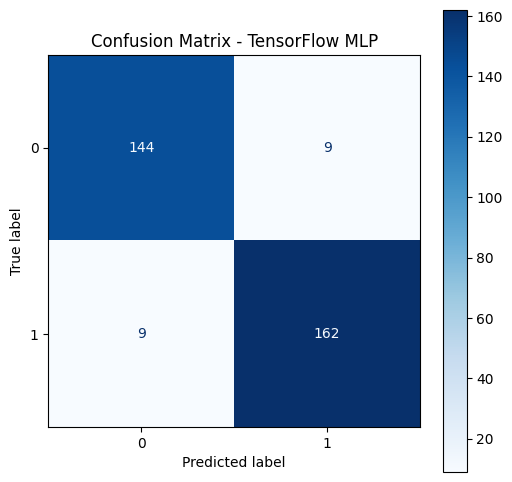

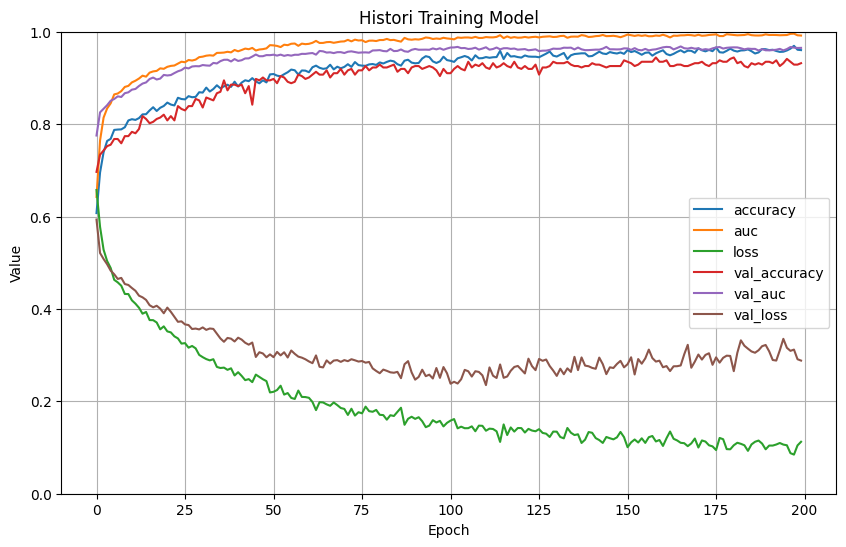


Proses pemodelan selesai.


In [20]:
if __name__ == "__main__":
    # 1. Persiapan Data
    df = load_data(FILE_PATH)
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(df, TARGET_COLUMN)
    
    preprocessor = create_preprocessor(NUMERICAL_COLS, CATEGORICAL_COLS)
    X_train_processed = preprocessor.fit_transform(X_train)
    X_val_processed = preprocessor.transform(X_val)
    X_test_processed = preprocessor.transform(X_test)
    
    print(f"Bentuk data setelah preprocessing: {X_train_processed.shape}")
    joblib.dump(preprocessor, PREPROCESSOR_PATH)
    print(f"Preprocessor disimpan di: {PREPROCESSOR_PATH}")

    # 2. Pembangunan Model
    MODEL_CONFIG['input_shape'] = X_train_processed.shape[1]
    model = build_model(MODEL_CONFIG)
    model.summary()
    
    # 3. Pelatihan Model
    history = train_model(
        model, 
        X_train_processed, y_train.values, 
        X_val_processed, y_val.values, 
        MODEL_CONFIG, MODEL_PATH
    )

    # 4. Evaluasi Model
    # Muat model dengan bobot terbaik yang disimpan selama pelatihan
    best_model = tf.keras.models.load_model(MODEL_PATH)
    evaluate_model(best_model, X_test_processed, y_test.values, "TensorFlow MLP")

    # 5. Visualisasi Hasil Pelatihan
    plot_training_history(history)
    
    print("\nProses pemodelan selesai.")